# KNN Algorithm - Experiments

## External lib Imports

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
sns.set()

## Loading the dataset

In [2]:
# raw_df = pd.read_csv('../protein-data-set/pdb_data_no_dups.csv')
# complete = raw_df.dropna()
# df = complete.loc[complete["macromoleculeType"].isin(["DNA", "RNA"])]
df = pd.read_csv('normalized_dataset.csv')
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   structureId               1046 non-null   object 
 1   classification            1046 non-null   object 
 2   experimentalTechnique     1046 non-null   object 
 3   macromoleculeType         1046 non-null   object 
 4   residueCount              1046 non-null   float64
 5   resolution                1046 non-null   float64
 6   structureMolecularWeight  1046 non-null   float64
 7   crystallizationMethod     1046 non-null   object 
 8   crystallizationTempK      1046 non-null   float64
 9   densityMatthews           1046 non-null   float64
 10  densityPercentSol         1046 non-null   float64
 11  pdbxDetails               1046 non-null   object 
 12  phValue                   1046 non-null   float64
 13  publicationYear           1046 non-null   float64
dtypes: float

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount,1046.0,0.161252,0.176538,0.0,0.061674,0.079295,0.185022,1.0
resolution,1046.0,0.471832,0.199016,0.0,0.324167,0.453333,0.633333,1.0
structureMolecularWeight,1046.0,0.167043,0.181501,0.0,0.058923,0.082904,0.203352,1.0
crystallizationTempK,1046.0,0.458200,0.204906,0.0,0.400000,0.500000,0.550000,1.0
densityMatthews,1046.0,0.338491,0.196870,0.0,0.216495,0.278351,0.419244,1.0
densityPercentSol,1046.0,0.489044,0.161379,0.0,0.388723,0.465054,0.590074,1.0
phValue,1046.0,0.463270,0.181922,0.0,0.277778,0.551389,0.555556,1.0
publicationYear,1046.0,2006.444551,7.291752,1985.0,2001.000000,2007.000000,2012.000000,2017.0


In [4]:
features = [
    'residueCount',
    'resolution',
    'structureMolecularWeight',
    'crystallizationTempK',
    'densityMatthews',
    'densityPercentSol',
    'phValue'
]

In [5]:
df.head(5)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,102D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.533333,0.079033,"VAPOR DIFFUSION, SITTING DROP",0.1,0.271478,0.449662,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",0.555556,1995.0
1,110D,DNA,X-RAY DIFFRACTION,DNA,0.000000,0.433333,0.007167,"VAPOR DIFFUSION, SITTING DROP",0.1,0.484536,0.631381,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",0.444444,1993.0
2,111D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.550000,0.075475,"VAPOR DIFFUSION, SITTING DROP",0.1,0.274914,0.452646,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",0.444444,1989.0
3,113D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.633333,0.075231,"VAPOR DIFFUSION, SITTING DROP",0.2,0.295533,0.473692,"pH 7.40, VAPOR DIFFUSION, SITTING DROP, temper...",0.666667,1987.0
4,117D,DNA,X-RAY DIFFRACTION,DNA,0.026432,0.650000,0.025144,VAPOR DIFFUSION,0.1,0.522337,0.654311,"pH 6.50, VAPOR DIFFUSION, temperature 277.00K",0.416667,1992.0


## Distance Functions

> We employ the distance funcions present in the scipy package
>
>>euclidean
>>
>>canberra

In [6]:
def get_neighbors(
    train_set: pd.DataFrame,
    test_sample: pd.Series,
    columns: list,
    k: int,
    metric: str='euclidean') -> pd.DataFrame:
    """docstring"""
    
    train_set["distance"] = cdist(
        np.array(train_set[features]),
        np.array(test_sample),
        metric
    )
    
        
    return train_set.sort_values("distance").iloc[-k:].reset_index()

In [7]:
# Test data
X_train, X_test, y_train, y_test = train_test_split(
    df, df['macromoleculeType'], test_size=0.33, random_state=42)

print(y_test)

773     DNA
280     DNA
629     DNA
318     DNA
1008    RNA
       ... 
917     DNA
491     DNA
852     DNA
177     DNA
1001    DNA
Name: macromoleculeType, Length: 346, dtype: object


## Voting functions

> Standard
>
> Harmonic
>
> Inverse of distance

In [8]:
def standard_vote(neighbors: pd.DataFrame, column: str):
    
    votes = neighbors[column].value_counts()
    winner_id = votes.argmax()
    print(votes.describe())

    return votes.index[winner_id]

candidate = X_test.sample(1)
neighbors_df = get_neighbors(X_train, candidate[features], features, 13)
print(candidate["macromoleculeType"], '\n')
print(standard_vote(neighbors_df, "macromoleculeType"))

529    RNA
Name: macromoleculeType, dtype: object 

count     2.000000
mean      6.500000
std       6.363961
min       2.000000
25%       4.250000
50%       6.500000
75%       8.750000
max      11.000000
Name: macromoleculeType, dtype: float64
DNA


<ipython-input-6-defe9f7026f1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["distance"] = cdist(


In [9]:
# # Example
# def vote_distance_weights(neighbors, all_results=True):
#     class_counter = Counter()
#     number_of_neighbors = len(neighbors)
#     for index in range(number_of_neighbors):
#         dist = neighbors[index][1]
#         label = neighbors[index][2]
#         class_counter[label] += 1 / (dist + 1)
#     labels, votes = zip(*class_counter.most_common())
#     #print(labels, votes)
#     winner = class_counter.most_common(1)[0][0]
#     votes4winner = class_counter.most_common(1)[0][1]
#     if all_results:
#         total = sum(class_counter.values(), 0.0)
#         for key in class_counter:
#              class_counter[key] /= total
#         return winner, class_counter.most_common()
#     else:
#         return winner, votes4winner / sum(votes)

In [10]:
def knn_standard(metric, train_set, test_set, k):
    """
    Classification using KNN
    """
    
    target_labels =[]
    
    for target in test_set.iterrows():
        working_df = train_set.copy()
        
        working_df['distance'] = [
            cdist(np.array(line), target, metric) for line in train_set.iterrows()
        ]
    
    pass

a = pd.DataFrame([[1,1,1,1,1], [2,2,2,2,2]])

In [11]:
def harmonic(distances: np.array) -> np.array:
    """
    Calculate harmonic weights using a distance array 
    """
    
    weights = np.zeros(distances.shape)
    
    for i, pos in enumerate(distances.argsort()):
        weights[0][pos] = 1 / (i + 1)
    
    return weights

### Experiments configs

In [41]:
"""
Each model presents a "p" parameter that set the
distance metric employed based on the minkowski formula.

1 -> manhattan;
2 -> euclidean;
p > 2: minkowski for p; 

"""

# Default KNN configs
#
NUM_NEIGHBORS = 5
p = 1


standard_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'p': p
}

harmonic_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'weights': harmonic,
    'p': p
}

distance_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'weights': 'distance',
    'p': p
}

### Classification function

In [42]:
def classification(
    features: pd.DataFrame,
    target: np.array,
    knn_params: dict,
    n_splits: int) -> list:
    """docstring"""
    
    model = KNeighborsClassifier(**knn_params)
    kf = KFold(n_splits=n_splits)

    results = []
    valids = []

    for train_idx, test_idx in kf.split(features):

        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]

        model.fit(X_train, y_train)
                
        predicts = [
            model.predict(np.array([list(row)]))[0]
            for _, row in X_test.iterrows()
        ]
        
        results.append(predicts)
        valids.append(y_test)

    return results, valids

### KNN with harmonic weights

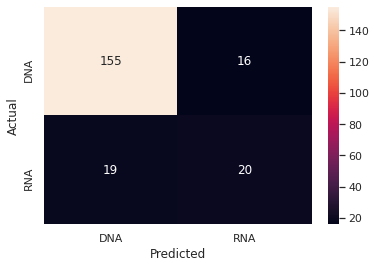

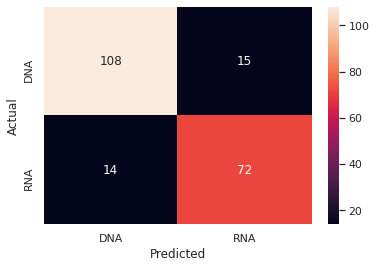

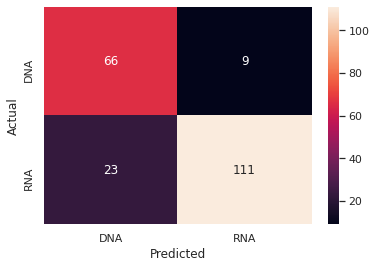

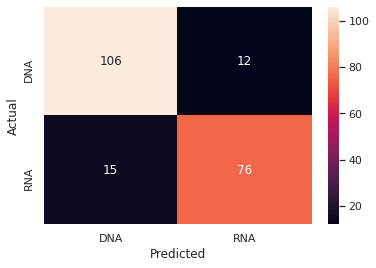

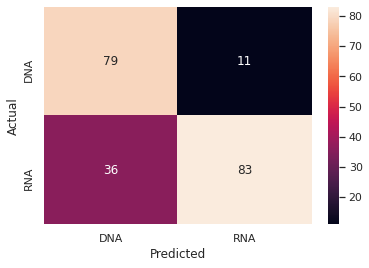

In [47]:
predictions, valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    harmonic_params,
    n_splits=5
)

for pred, valid in zip(predictions, valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()


### Standard KNN

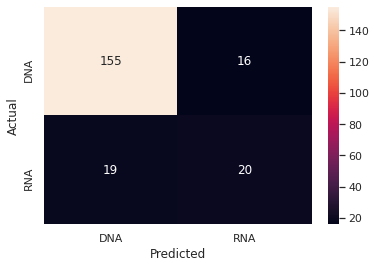

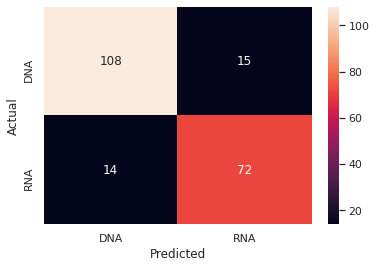

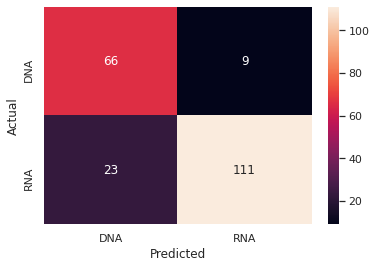

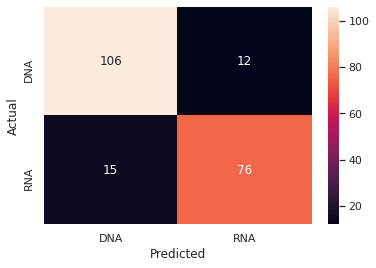

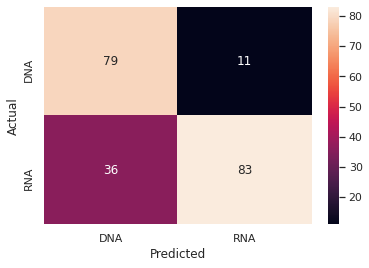

In [48]:
std_preds, std_valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    standard_params,
    n_splits=5
)

for pred, valid in zip(std_preds, std_valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()

### Inverse Distance Weight KNN

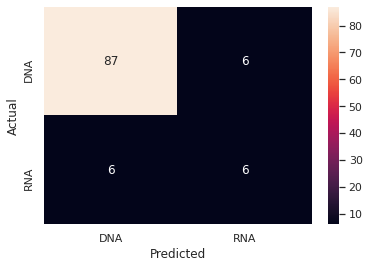

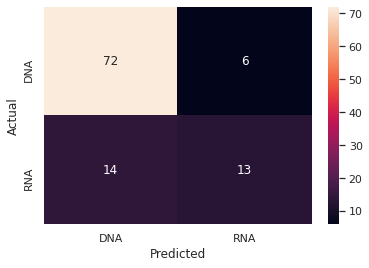

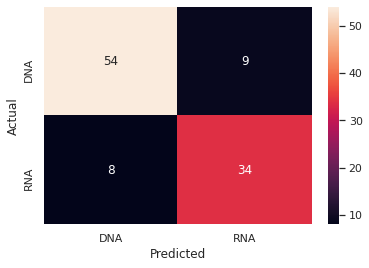

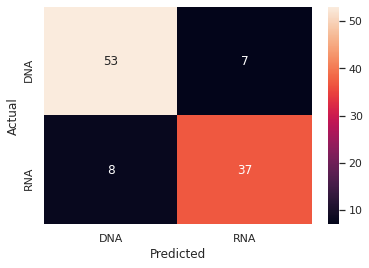

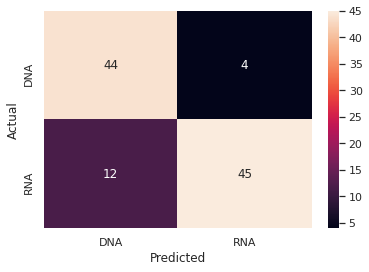

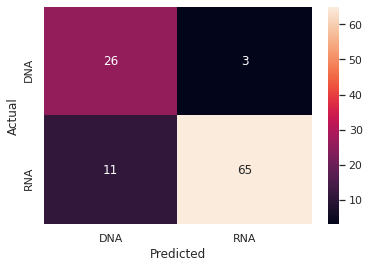

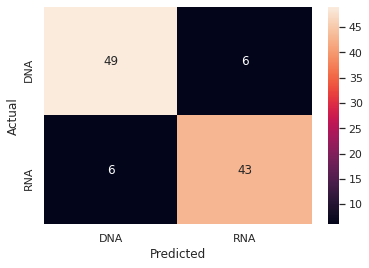

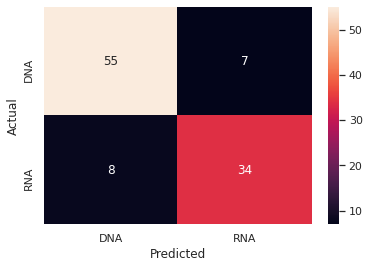

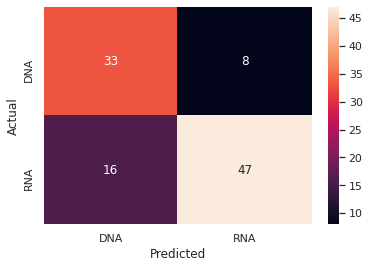

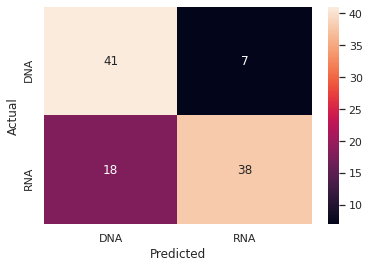

In [50]:
dist_preds, dist_valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    distance_params,
    n_splits=10
)

for pred, valid in zip(dist_preds, dist_valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()